# 0.0 IMPORTS

In [125]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
import warnings
import umap.umap_ as umap

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

import skopt

import sklearn.metrics as mt
import sklearn.model_selection as ms

warnings.filterwarnings('ignore')

## 0.1 Loading Data

In [2]:
path = 'C://Users/edils/repos/cases_rh/Cases/Geofusion/data/'

In [3]:
df_raw = pd.read_csv(path + 'X_train.csv', encoding='ISO-8859-1', sep=';')

In [4]:
df_train = df_raw.loc[df_raw['cidade'] == 'Rio de Janeiro']

In [5]:
X_test = df_raw.loc[df_raw['cidade'] == 'São Paulo']

## 0.2 Helper Functions

In [6]:
def rename_columns(df1):
    cols_new = df1.columns.map(lambda x: inflection.underscore(x))
    df1.columns = cols_new
    
    return df1

def replace_strings(valor):
    if isinstance(valor, str):
        return np.nan
    return valor


def change_types(df1):
    
    df1['renda_media'] = df1['renda_media'].astype(float)


def pre_processing(df4):
    #minmax
    columns_minmax = ['população', 'pop_ate9', 'pop_de10a14', 'pop_de15a19',
       'pop_de20a24', 'pop_de25a34', 'pop_de35a49', 'pop_de50a59',
       'pop_mais_de60', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1',
       'domicilios_b2', 'domicilios_c1', 'domicilios_c2', 'domicilios_d',
       'domicilios_e', 'renda_media']

    mms = pp.MinMaxScaler()

    for col in columns_minmax:
        df4[col] = mms.transform(df4[col].values.reshape(-1,1))
    
    #standard
    ss = pp.StandardScaler()

    df4['faturamento'] = ss.transform(df4['faturamento'].values.reshape(-1,1))
    
    return df4

def regression_error(model, y, yhat):
    
    mae = mt.mean_absolute_error(y, yhat)
    mape = mt.mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))
        
    df = pd.DataFrame({
        'Modelo':model.__name__,
        'MAE':mae,
        'MAPE':mape,
        'RMSE':rmse
        
    }, index=[0])
    
    return df

def classification_metrics(model, y_true, y_pred):
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision_micro = mt.precision_score(y_true, y_pred, average='micro')
    recall_micro = mt.recall_score(y_true, y_pred, average='micro')
    f1_micro = mt.f1_score(y_true, y_pred, average='micro')
    precision_macro = mt.precision_score(y_true, y_pred, average='macro')
    recall_macro = mt.recall_score(y_true, y_pred, average='macro')
    f1_macro = mt.f1_score(y_true, y_pred, average='macro')
    
    df = pd.DataFrame({
        'Modelo': [model.__name__],
        'Accuracy': [accuracy],
        'Precision (micro)': [precision_micro],
        'Recall (micro)': [recall_micro],
        'F1 Score (micro)': [f1_micro],
        'Precision (macro)': [precision_macro],
        'Recall (macro)': [recall_macro],
        'F1 Score (macro)': [f1_macro]
    })
    
    return df

# 1.0 DATA DESCRIPTION

In [7]:
df1 = df_train.copy()

In [8]:
# #Analyze raw_dataset
# report = sweetviz.analyze(df_raw)
# report.show_html()

In [9]:
df1.sample(15)

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
146,3304557134,Vargem Grande,Rio de Janeiro,RJ,14436,2125,1003,1262,1149,2492,...,115,501,499,1288,1335,273,711,1884,768425.0,Baixo
49,3304557008,Estácio,Rio de Janeiro,RJ,17675,2246,980,1367,1462,2861,...,50,538,907,1760,1584,310,949,1631,764380.0,Baixo
108,3304557059,Piedade,Rio de Janeiro,RJ,44603,4657,2192,3121,3246,6454,...,95,2107,3222,4470,3969,500,1412,1944,808082.0,Alto
69,3304557066,Irajá,Rio de Janeiro,RJ,99102,9633,4743,6564,6855,14400,...,636,4874,8325,10129,6948,1222,3103,2140,1030856.0,Alto
26,3304557005,Catumbi,Rio de Janeiro,RJ,12910,1773,805,1018,999,1985,...,18,261,640,1281,1140,229,703,NaN,791170.0,Baixo
148,3304557159,Vasco Da Gama,Rio de Janeiro,RJ,15908,1909,878,1182,1320,2667,...,32,467,846,1612,1474,302,935,1550,767430.0,Baixo
133,3304557047,São Francisco Xavier,Rio de Janeiro,RJ,8578,972,502,613,758,1417,...,92,480,701,666,581,131,358,2317,878830.0,Baixo
39,3304557105,Cosmos,Rio de Janeiro,RJ,79116,11524,5711,7144,6478,12238,...,0,1032,3321,7860,7050,1914,4347,1308,219983.0,Médio
79,3304557129,Joá,Rio de Janeiro,RJ,842,61,29,35,46,131,...,59,57,33,7,8,0,20,17659,1162364.0,Médio
109,3304557061,Pilares,Rio de Janeiro,RJ,28018,3008,1476,1999,1993,4011,...,0,913,1659,2729,1997,456,2074,1535,826523.0,Baixo


## 1.1 Rename Columns

In [10]:
cols_new = df1.columns.map(lambda x: inflection.underscore(x))
df1.columns = cols_new

## 1.2 Data Shape

In [11]:
df1.shape

(160, 24)

## 1.3 Data Types

In [12]:
df1.dtypes

codigo             int64
nome              object
cidade            object
estado            object
população          int64
pop_ate9           int64
pop_de10a14        int64
pop_de15a19        int64
pop_de20a24        int64
pop_de25a34        int64
pop_de35a49        int64
pop_de50a59        int64
pop_mais_de60      int64
domicilios_a1      int64
domicilios_a2      int64
domicilios_b1      int64
domicilios_b2      int64
domicilios_c1      int64
domicilios_c2      int64
domicilios_d       int64
domicilios_e       int64
renda_media       object
faturamento      float64
potencial         object
dtype: object

In [13]:
df1['renda_media'] = df1['renda_media'].astype(float)

## 1.3 Check NaN

In [14]:
df1.isna().sum()

codigo           0
nome             0
cidade           0
estado           0
população        0
pop_ate9         0
pop_de10a14      0
pop_de15a19      0
pop_de20a24      0
pop_de25a34      0
pop_de35a49      0
pop_de50a59      0
pop_mais_de60    0
domicilios_a1    0
domicilios_a2    0
domicilios_b1    0
domicilios_b2    0
domicilios_c1    0
domicilios_c2    0
domicilios_d     0
domicilios_e     0
renda_media      6
faturamento      0
potencial        0
dtype: int64

In [15]:
df1['renda_media'] = df1['renda_media'].fillna(df1['renda_media'].mean())

## 1.5 Descriptive Statistics

### 1.5.1 Numerical Statistics

In [16]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [17]:
disp = num_attributes.agg(['min', 'max', lambda x: max(x)-min(x), 'mean','median','std','skew','kurtosis']).T

In [18]:
disp

,min,max,<lambda>,mean,median,std,skew,kurtosis
codigo,3.304557e+09,3.304557e+09,159.0,3.304557e+09,3.304557e+09,46.332134,0.000000,-1.200000
população,1.730000e+02,6.676030e+05,667430.0,4.265435e+04,2.607600e+04,64262.949072,6.430261,56.987523
pop_ate9,3.300000e+01,1.225780e+05,122545.0,5.329062e+03,3.111500e+03,10816.199770,8.455441,87.995016
pop_de10a14,1.300000e+01,5.593500e+04,55922.0,2.484444e+03,1.434000e+03,4948.827166,8.385443,86.769750
pop_de15a19,2.200000e+01,6.234200e+04,62320.0,3.272156e+03,2.015000e+03,5752.156303,7.401606,71.038687
pop_de20a24,1.700000e+01,6.056700e+04,60550.0,3.349381e+03,2.142500e+03,5601.893201,7.253694,69.287685
pop_de25a34,2.800000e+01,8.611600e+04,86088.0,6.584475e+03,4.170500e+03,9049.895783,5.159097,38.471855
pop_de35a49,3.800000e+01,1.053160e+05,105278.0,8.826862e+03,5.657000e+03,11536.276416,4.691357,32.096439
pop_de50a59,1.000000e+01,8.334100e+04,83331.0,5.332262e+03,3.371500e+03,7986.261929,6.495919,57.988745
pop_mais_de60,1.200000e+01,9.140800e+04,91396.0,7.475706e+03,4.575500e+03,10258.307743,4.725239,30.969842


### 1.5.2 Categorical Attributes

In [19]:
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

In [20]:
cat_attributes

,nome,cidade,estado,potencial
0,Abolição,Rio de Janeiro,RJ,Médio
1,Acari,Rio de Janeiro,RJ,Baixo
2,Água Santa,Rio de Janeiro,RJ,Baixo
3,Alto Da Boa Vista,Rio de Janeiro,RJ,Médio
4,Anchieta,Rio de Janeiro,RJ,Médio
...,...,...,...,...
155,Vila Kosmos,Rio de Janeiro,RJ,Médio
156,Vila Militar,Rio de Janeiro,RJ,Médio
157,Vila Valqueire,Rio de Janeiro,RJ,Alto
158,Vista Alegre,Rio de Janeiro,RJ,Baixo


<Axes: xlabel='potencial', ylabel='count'>

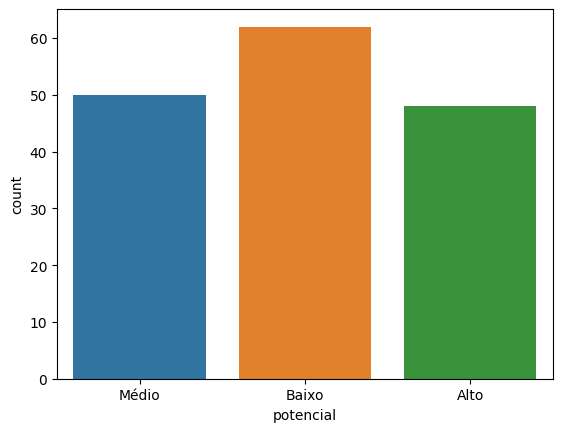

In [21]:
#name 
sns.countplot(cat_attributes, x='potencial')

# 2.0 FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

In [23]:
#remove city, state, ID
df2 = df2.drop(['cidade', 'estado', 'codigo'], axis=1)


# 3.0 EDA

In [24]:
df3 = df2.copy()

# 4.0 DATA PREPARATION

In [25]:
df4 = df3.copy()

In [26]:
df4.head()

,nome,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,...,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
0,Abolição,11676,1027,483,688,800,1675,2300,1784,2919,...,145,715,1242,1093,758,92,304,2501.0,932515.0,Médio
1,Acari,27564,5131,2188,2697,2630,4810,5308,2403,2397,...,0,82,506,2040,2490,827,2506,931.0,588833.0,Baixo
2,Água Santa,9003,883,399,597,762,1755,2076,1112,1419,...,96,404,652,644,522,77,254,2391.0,874200.0,Baixo
3,Alto Da Boa Vista,9606,1072,538,660,685,1317,2007,1341,1986,...,178,393,517,945,584,137,286,3727.0,912226.0,Médio
4,Anchieta,57222,7677,3774,4892,4600,8660,12272,7157,8190,...,0,1089,2821,5110,5422,1073,3261,1380.0,553020.0,Médio


In [27]:
#potencial
df4['potencial'] = df4['potencial'].apply(lambda x: 0 if x == 'Baixo' else 1 if x == 'Médio' else 2)

<Axes: xlabel='faturamento', ylabel='Count'>

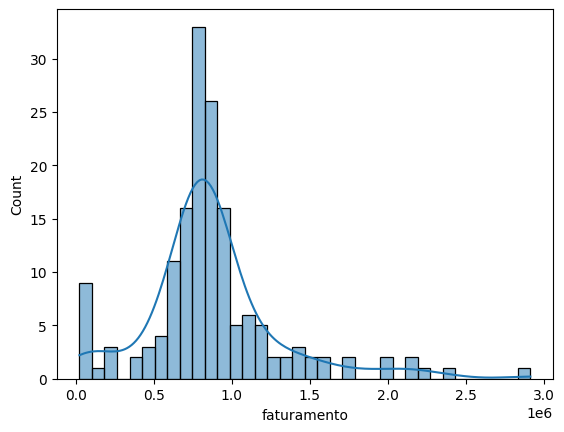

In [28]:
sns.histplot(df4, x='faturamento', kde=True)

## 4.1 MinMaxScaler

In [29]:
df4.columns

Index(['nome', 'população', 'pop_ate9', 'pop_de10a14', 'pop_de15a19',
       'pop_de20a24', 'pop_de25a34', 'pop_de35a49', 'pop_de50a59',
       'pop_mais_de60', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1',
       'domicilios_b2', 'domicilios_c1', 'domicilios_c2', 'domicilios_d',
       'domicilios_e', 'renda_media', 'faturamento', 'potencial'],
      dtype='object')

In [30]:
columns_minmax = ['população', 'pop_ate9', 'pop_de10a14', 'pop_de15a19',
       'pop_de20a24', 'pop_de25a34', 'pop_de35a49', 'pop_de50a59',
       'pop_mais_de60', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1',
       'domicilios_b2', 'domicilios_c1', 'domicilios_c2', 'domicilios_d',
       'domicilios_e', 'renda_media']

mms = pp.MinMaxScaler()

for col in columns_minmax:
    df4[col] = mms.fit_transform(df4[col].values.reshape(-1,1))

## 4.2 StandScaler

In [31]:
ss = pp.StandardScaler()

df4['faturamento'] = ss.fit_transform(df4['faturamento'].values.reshape(-1,1))

# 5.0 FEATURE SELECTION

In [32]:
df5 = df4.copy()

In [33]:
df5.head()

,nome,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,...,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
0,Abolição,0.017235,0.008111,0.008405,0.010687,0.012931,0.019132,0.021486,0.021289,0.031807,...,0.012427,0.036951,0.058483,0.032864,0.029291,0.018563,0.020363,0.029209,0.129006,1
1,Acari,0.041040,0.041601,0.038893,0.042924,0.043154,0.055548,0.050058,0.028717,0.026095,...,0.000000,0.004238,0.023826,0.061469,0.096485,0.166868,0.168836,0.004381,-0.657741,0
2,Água Santa,0.013230,0.006936,0.006902,0.009227,0.012304,0.020061,0.019358,0.013224,0.015395,...,0.008228,0.020879,0.030701,0.019302,0.020135,0.015537,0.016991,0.027470,-0.004487,0
3,Alto Da Boa Vista,0.014133,0.008479,0.009388,0.010237,0.011032,0.014973,0.018703,0.015972,0.021598,...,0.015255,0.020310,0.024344,0.028394,0.022540,0.027643,0.019149,0.048598,0.082561,1
4,Anchieta,0.085476,0.062377,0.067254,0.078145,0.075690,0.100269,0.116207,0.085766,0.089479,...,0.000000,0.056279,0.132834,0.154202,0.210234,0.216505,0.219742,0.011481,-0.739723,1


## 5.1 Random Forest Selection

In [34]:
X_train = df5.drop(['nome','faturamento','potencial'], axis=1).copy()
y_train = df5['faturamento'].copy()

In [35]:
rf = RandomForestRegressor(n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [36]:
importances = rf.feature_importances_
columns_importances = X_train.columns

In [37]:
importance_dict = {}
for key, value in zip(columns_importances, importances):
    importance_dict[key] = value
    
df_importance = pd.DataFrame(importance_dict, index=[0]).T.rename(columns={0:'Ranking'})

In [38]:
df_importance.sort_values(by='Ranking', ascending=False)

,Ranking
domicilios_a1,0.469542
domicilios_a2,0.212493
domicilios_e,0.145198
renda_media,0.049343
domicilios_d,0.049046
pop_ate9,0.017750
domicilios_c2,0.017297
pop_de10a14,0.008956
pop_mais_de60,0.006850
domicilios_b1,0.005558


## 6.0 Machine Learning

## 6.1 Split Validation and Training

In [39]:
X_train = df5.drop(['nome','faturamento','potencial'], axis=1).copy()
y_train = df5['faturamento'].copy()

In [40]:
X_test_reg = rename_columns(X_test)
X_test_reg['renda_media'] = X_test_reg['renda_media'].replace('-', np.nan)
X_test_reg['renda_media'] = X_test_reg['renda_media'].astype(float)
X_test_reg['renda_media'] = X_test_reg['renda_media'].fillna(X_test_reg['renda_media'].mean())

In [41]:
model_list = [LinearRegression, 
              SVR,  
              RandomForestRegressor, 
              XGBRegressor, 
              LGBMRegressor,
              CatBoostRegressor]

In [42]:
for model in model_list:
    if model.__name__ == 'CatBoostRegressor':
        mds = model(verbose=False)
    else:
        mds = model()
    kfold = ms.KFold(n_splits=10)
    s = ms.cross_val_score(mds, X_train, y_train, scoring='r2', cv=kfold)
    print(f"{model.__name__:22} R2 Score: {s.mean():.3f} +/- {s.std():.3f} ")

LinearRegression       R2 Score: 0.018 +/- 2.374 
SVR                    R2 Score: 0.697 +/- 0.344 
RandomForestRegressor  R2 Score: 0.881 +/- 0.082 
XGBRegressor           R2 Score: 0.904 +/- 0.056 
LGBMRegressor          R2 Score: 0.682 +/- 0.315 
CatBoostRegressor      R2 Score: 0.927 +/- 0.058 


In [43]:
X_train = df3.drop(['nome','faturamento','potencial'], axis=1).copy()
y_train = df3['faturamento'].copy()
X_train_reg, X_val, y_train_reg, y_val = ms.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [44]:
X_train

,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media
0,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501.0
1,27564,5131,2188,2697,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931.0
2,9003,883,399,597,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391.0
3,9606,1072,538,660,685,1317,2007,1341,1986,114,178,393,517,945,584,137,286,3727.0
4,57222,7677,3774,4892,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,18791,1802,921,1442,1462,2500,3944,2920,3800,0,259,774,1363,1923,1379,190,405,2316.0
156,13556,1888,787,1042,982,2542,2908,1528,1879,0,219,714,828,1051,1012,116,465,2416.0
157,33190,3166,1619,2255,2326,4752,7183,4950,6939,0,906,2866,2241,2982,1200,360,772,3189.0
158,8867,724,387,580,565,1205,1812,1474,2120,0,87,556,836,940,484,75,214,2418.0


## 6.1 Random Forest Regressor

In [45]:
model_rf = RandomForestRegressor(n_jobs=-1, random_state=42)

model_rf.fit(X_train_reg, y_train_reg)

yhat_rf = model_rf.predict(X_val)

In [46]:
rf_error = regression_error(RandomForestRegressor, y_val, yhat_rf)

## 6.2 XGBoost Regressor

In [47]:
model_xgb = XGBRegressor(random_state=42)

model_xgb.fit(X_train_reg, y_train_reg)

yhat_xgb = model_xgb.predict(X_val)

In [48]:
xgb_error = regression_error(XGBRegressor, y_val, yhat_xgb)

## 6.3 CatboostRegressor

In [49]:
model_cat = CatBoostRegressor(random_state=42, verbose=False)

model_cat.fit(X_train_reg, y_train_reg)

cat_error = yhat_cat = model_cat.predict(X_val)

In [50]:
cat_error = regression_error(CatBoostRegressor, y_val, yhat_cat)

## 6.4 Compare Models

In [51]:
df_compare = pd.DataFrame()
df_compare = pd.concat([rf_error, xgb_error, cat_error])
df_compare.sort_values(by='RMSE')

,Modelo,MAE,MAPE,RMSE
0,XGBRegressor,89393.518066,0.085659,144947.772808
0,RandomForestRegressor,95204.485625,0.097258,167035.755028
0,CatBoostRegressor,111220.614795,0.082948,268968.023491


## 6.5 Cross Validation

In [52]:
model_cross_list = [RandomForestRegressor, 
                    XGBRegressor, 
                    CatBoostRegressor]

for model in model_cross_list:
    if model == CatBoostRegressor:
        mds = model(verbose=False)
    else:
        mds = model()
    kfold = ms.KFold(n_splits=10)
    s = ms.cross_val_score(mds, X_train, ss.inverse_transform(np.array(y_train).reshape(-1,1)), scoring='neg_mean_absolute_percentage_error', cv=kfold)
    print(f"{model.__name__:22} MAPE: {s.mean():.3f} +/- {s.std():.3f} ")

RandomForestRegressor  MAPE: -0.204 +/- 0.106 
XGBRegressor           MAPE: -0.180 +/- 0.103 
CatBoostRegressor      MAPE: -0.159 +/- 0.097 


## 7.0 Modelo Escolhido CatBoost

In [53]:
# #Fine Tuning
# search_space = {
#     'iterations': (100, 1000),  # Número de iterações
#     'learning_rate': (0.01, 0.5),  # Taxa de aprendizado
#     'depth': (3, 10),  # Profundidade da árvore
#     'l2_leaf_reg': (1, 10),  # Regularização L2
#     'bagging_temperature': (0.0, 1.0),  # Temperatura de amostragem
#     'border_count': (1, 255)  # Contagem de borda
# }

# bayes_search = skopt.BayesSearchCV(estimator=CatBoostRegressor(verbose=False), search_spaces=search_space, n_iter=50, random_state=42)

In [54]:
# bayes_search.fit(X_train, y_train)
# best_params = bayes_search.best_params_
# final_model = CatBoostRegressor(**best_params, random_state=42, verbose=False)

# final_model.fit(X_train_reg, y_train_reg)

# yhat_final_cat = final_model.predict(X_val)
# regression_error(CatBoostRegressor, ss.inverse_transform(np.array(y_val).reshape(-1,1)), ss.inverse_transform(yhat_final_cat.reshape(-1,1)))

# 8.0 Predict on Test

In [55]:
X_test_reg = X_test_reg.drop(['codigo','nome','cidade','estado','faturamento','potencial'], axis=1)

In [56]:
yhat_test = model_xgb.predict(X_test_reg)

In [57]:
faturamentos_sp = yhat_test

In [58]:
X_test_reg = X_test.copy()

In [59]:
X_test_reg['faturamento'] = faturamentos_sp

In [60]:
X_test_reg

,codigo,nome,cidade,estado,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,...,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,...,253,2197,4368,6681,7011,2247,5670,1501.0,2.402675e+05,NaN
161,35503020,Aclimação,São Paulo,SP,32791,2297,1017,2096,2197,5341,...,1734,3704,2351,1946,827,291,1617,5920.0,1.525346e+06,NaN
162,355030285,Adventista,São Paulo,SP,104193,15070,7343,10631,8657,17749,...,0,1423,4875,8595,10082,3111,5776,1284.0,1.860776e+05,NaN
163,35503088,Água Branca,São Paulo,SP,12721,953,343,627,819,2142,...,667,1558,1032,915,361,84,404,6278.0,1.267278e+06,NaN
164,35503066,Água Funda,São Paulo,SP,48417,5078,2396,4018,3571,7388,...,303,1794,2986,4489,2836,1104,2553,1905.0,7.460072e+05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,355030213,Vila Sônia,São Paulo,SP,34061,2908,1462,2253,2076,4579,...,1089,2866,2219,2216,1227,306,1098,5285.0,1.262652e+06,NaN
452,355030207,Vila Suzana,São Paulo,SP,35403,4127,1890,2678,2433,5855,...,1522,2458,1186,1166,918,209,3840,7418.0,1.467358e+06,NaN
453,355030162,Vila Terezinha,São Paulo,SP,122359,18304,9304,13258,9965,19248,...,0,1758,4517,9450,11473,3218,7540,1252.0,7.132221e+04,NaN
454,355030157,Vila Zatt,São Paulo,SP,125864,14670,7305,11225,9338,18841,...,872,5093,8063,10012,8082,2856,6853,1936.0,1.078105e+05,NaN


# 9.0 Classificator

## 9.1 Random Forest Importances

In [61]:
X_train_class = df5.drop(['nome','potencial'], axis=1).copy()
y_train_class = df5['potencial'].copy()

rf = RandomForestClassifier(n_jobs=-1)

rf.fit(X_train_class, y_train_class)

importances = rf.feature_importances_
columns_importances = X_train_class.columns

importance_dict = {}
for key, value in zip(columns_importances, importances):
    importance_dict[key] = value
    
df_importance = pd.DataFrame(importance_dict, index=[0]).T.rename(columns={0:'Ranking'})

df_importance.sort_values(by='Ranking', ascending=False)

,Ranking
domicilios_b1,0.191778
domicilios_a2,0.171842
renda_media,0.085232
pop_mais_de60,0.074361
domicilios_b2,0.073612
pop_de50a59,0.057528
faturamento,0.052111
pop_de35a49,0.048974
população,0.035362
domicilios_c1,0.034268



## 9.2 Model Selection

In [62]:
X_train = df5.drop(['nome','potencial'], axis=1).copy()
y_train = df5['potencial'].copy()


model_list = [KNeighborsClassifier,   
              RandomForestClassifier, 
              XGBClassifier, 
              LGBMClassifier,
              CatBoostClassifier]

In [63]:
for model in model_list:
    if model.__name__ == 'CatBoostClassifier':
        mds = model(verbose=False)
    elif model.__name__ == 'KNeighborsClassifier':
        mds = model(n_neighbors=3)
    else:
        mds=model()
    kfold = ms.KFold(n_splits=10)
    s = ms.cross_val_score(mds, X_train, y_train, scoring='accuracy', cv=kfold)
    print(f"{model.__name__:22} ACC score: {s.mean():.3f} +/- {s.std():.3f} ")

KNeighborsClassifier   ACC score: 0.781 +/- 0.064 
RandomForestClassifier ACC score: 0.881 +/- 0.034 
XGBClassifier          ACC score: 0.856 +/- 0.069 
LGBMClassifier         ACC score: 0.856 +/- 0.063 
CatBoostClassifier     ACC score: 0.869 +/- 0.081 


# 10.0 Models

In [64]:
df10 = df3.copy()

In [65]:
df10['potencial'] = df10['potencial'].apply(lambda x: 0 if x == 'Baixo' else 1 if x == 'Médio' else 2)

In [66]:
X_train = df10.drop(['nome','potencial'], axis=1).copy()
y_train = df10['potencial'].copy()
X_train_class, X_val_class, y_train_class, y_val_class = ms.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 10.1 RandomForestClassifier

In [67]:
model_rf_class = RandomForestClassifier(n_jobs=-1, random_state=42)

model_rf_class.fit(X_train_class, y_train_class)

yhat_rf_class = model_rf_class.predict(X_val_class)

In [68]:
metrics_rf = classification_metrics(RandomForestClassifier, y_val_class, yhat_rf_class)

## 10.2 XGBoost

In [69]:
model_xgb_class = XGBClassifier(random_state=42)

model_xgb_class.fit(X_train_class, y_train_class)

yhat_xgb_class = model_xgb_class.predict(X_val_class)

In [70]:
metrics_xgb = classification_metrics(XGBClassifier, y_val_class, yhat_xgb_class)

## 10.3 LGBM

In [71]:
model_lgb_class = LGBMClassifier(random_state=42)

model_lgb_class.fit(X_train_class, y_train_class)

yhat_lgb_class = model_lgb_class.predict(X_val_class)

In [72]:
metrics_lgb = classification_metrics(LGBMClassifier, y_val_class, yhat_lgb_class)

## 10.4 Catboost

In [73]:
model_cat_class = CatBoostClassifier(verbose=False, random_state=42)

model_cat_class.fit(X_train_class, y_train_class)

yhat_cat_class = model_cat_class.predict(X_val_class)

In [74]:
metrics_cat = classification_metrics(CatBoostClassifier, y_val_class, yhat_cat_class)

## 10.5 Compare Models

In [75]:
compare_class = pd.concat([metrics_rf, metrics_xgb, metrics_lgb, metrics_cat])
compare_class.sort_values(by='F1 Score (macro)', ascending=False)

,Modelo,Accuracy,Precision (micro),Recall (micro),F1 Score (micro),Precision (macro),Recall (macro),F1 Score (macro)
0,LGBMClassifier,0.96875,0.96875,0.96875,0.96875,0.966667,0.972222,0.967963
0,XGBClassifier,0.93750,0.93750,0.93750,0.93750,0.939394,0.944444,0.936364
0,CatBoostClassifier,0.93750,0.93750,0.93750,0.93750,0.935185,0.935185,0.935185
0,RandomForestClassifier,0.93750,0.93750,0.93750,0.93750,0.935185,0.935185,0.933977


# 11 Model - LGBM

In [76]:
X_test_class = X_test_reg.drop(['codigo', 'nome','cidade','estado','potencial'], axis=1)

In [77]:
X_test_class = rename_columns(X_test_class)
X_test_class['renda_media'] = X_test_class['renda_media'].replace('-', np.nan)
X_test_class['renda_media'] = X_test_class['renda_media'].astype(float)
X_test_class['renda_media'] = X_test_class['renda_media'].fillna(X_test_class['renda_media'].mean())

In [78]:
#predict
yhat_lgb_class_final = model_lgb_class.predict(X_test_class)

In [79]:
yhat_lgb_class_final

array([2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 0, 2, 2, 1, 2,
       2, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 0, 0, 2, 0, 1, 2,
       2, 0, 0, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1,
       2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 1, 1, 2,
       0, 1, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1,
       2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1,
       1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 0, 1, 1, 2, 1, 0,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1,
       1, 2, 1, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1,
       2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 2, 0, 0, 2, 1,
       0, 1, 2, 2, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 1, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2,
       1, 1, 2, 1, 1, 2, 2, 1, 2, 0], dtype=int64)

In [80]:
X_test_class = X_test_reg.copy()
X_test_class['potencial'] = yhat_lgb_class_final

In [81]:
X_test_class

,codigo,nome,cidade,estado,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,...,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,...,253,2197,4368,6681,7011,2247,5670,1501.0,2.402675e+05,2
161,35503020,Aclimação,São Paulo,SP,32791,2297,1017,2096,2197,5341,...,1734,3704,2351,1946,827,291,1617,5920.0,1.525346e+06,2
162,355030285,Adventista,São Paulo,SP,104193,15070,7343,10631,8657,17749,...,0,1423,4875,8595,10082,3111,5776,1284.0,1.860776e+05,1
163,35503088,Água Branca,São Paulo,SP,12721,953,343,627,819,2142,...,667,1558,1032,915,361,84,404,6278.0,1.267278e+06,2
164,35503066,Água Funda,São Paulo,SP,48417,5078,2396,4018,3571,7388,...,303,1794,2986,4489,2836,1104,2553,1905.0,7.460072e+05,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,355030213,Vila Sônia,São Paulo,SP,34061,2908,1462,2253,2076,4579,...,1089,2866,2219,2216,1227,306,1098,5285.0,1.262652e+06,2
452,355030207,Vila Suzana,São Paulo,SP,35403,4127,1890,2678,2433,5855,...,1522,2458,1186,1166,918,209,3840,7418.0,1.467358e+06,2
453,355030162,Vila Terezinha,São Paulo,SP,122359,18304,9304,13258,9965,19248,...,0,1758,4517,9450,11473,3218,7540,1252.0,7.132221e+04,1
454,355030157,Vila Zatt,São Paulo,SP,125864,14670,7305,11225,9338,18841,...,872,5093,8063,10012,8082,2856,6853,1936.0,1.078105e+05,2


# 12.0 EMBEDDING

In [105]:
X_train_embedding = X_test_class

In [106]:
#selecionar publico alvo
X_train_embedding.columns

Index(['codigo', 'nome', 'cidade', 'estado', 'população', 'pop_ate9',
       'pop_de10a14', 'pop_de15a19', 'pop_de20a24', 'pop_de25a34',
       'pop_de35a49', 'pop_de50a59', 'pop_mais_de60', 'domicilios_a1',
       'domicilios_a2', 'domicilios_b1', 'domicilios_b2', 'domicilios_c1',
       'domicilios_c2', 'domicilios_d', 'domicilios_e', 'renda_media',
       'faturamento', 'potencial'],
      dtype='object')

In [107]:
X_train_emb_alvo = X_train_embedding.loc[:,['pop_de25a34','pop_de35a49','domicilios_a1','domicilios_a2','domicilios_b1','domicilios_b2','renda_media','faturamento','potencial']]

In [108]:
X_train_emb_alvo

,pop_de25a34,pop_de35a49,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,renda_media,faturamento,potencial
160,14535,21549,0,253,2197,4368,1501.0,2.402675e+05,2
161,5341,7281,1413,1734,3704,2351,5920.0,1.525346e+06,2
162,17749,23364,0,0,1423,4875,1284.0,1.860776e+05,1
163,2142,2833,624,667,1558,1032,6278.0,1.267278e+06,2
164,7388,10751,0,303,1794,2986,1905.0,7.460072e+05,2
...,...,...,...,...,...,...,...,...,...
451,4579,7557,942,1089,2866,2219,5285.0,1.262652e+06,2
452,5855,9107,1726,1522,2458,1186,7418.0,1.467358e+06,2
453,19248,26592,0,0,1758,4517,1252.0,7.132221e+04,1
454,18841,28500,8,872,5093,8063,1936.0,1.078105e+05,2


## 12.1 Find Clusters

In [109]:
clusters = np.arange(2,15,1)

In [110]:
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

Text(0.5, 1.0, 'WSS vs K')

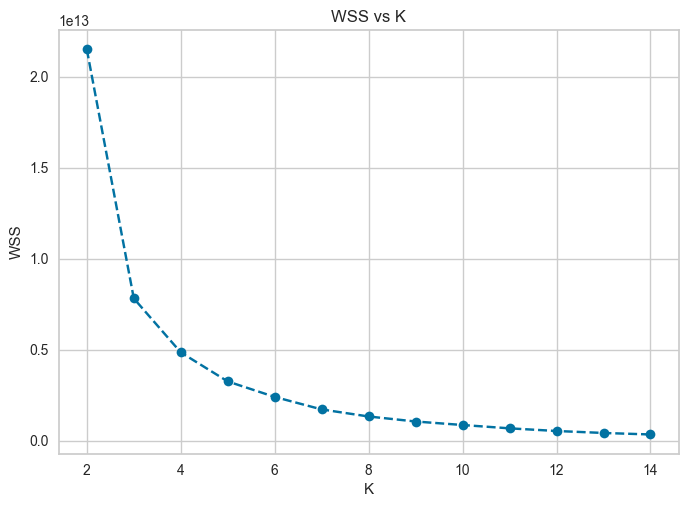

In [111]:
#WSS
wss = []

for k in clusters: 
    kmeans = KMeans(n_clusters=k, init='k-means++')

    kmeans.fit(X_train_emb_alvo)
    
    wss.append(kmeans.inertia_)
    
#elbow method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('WSS')
plt.title('WSS vs K')

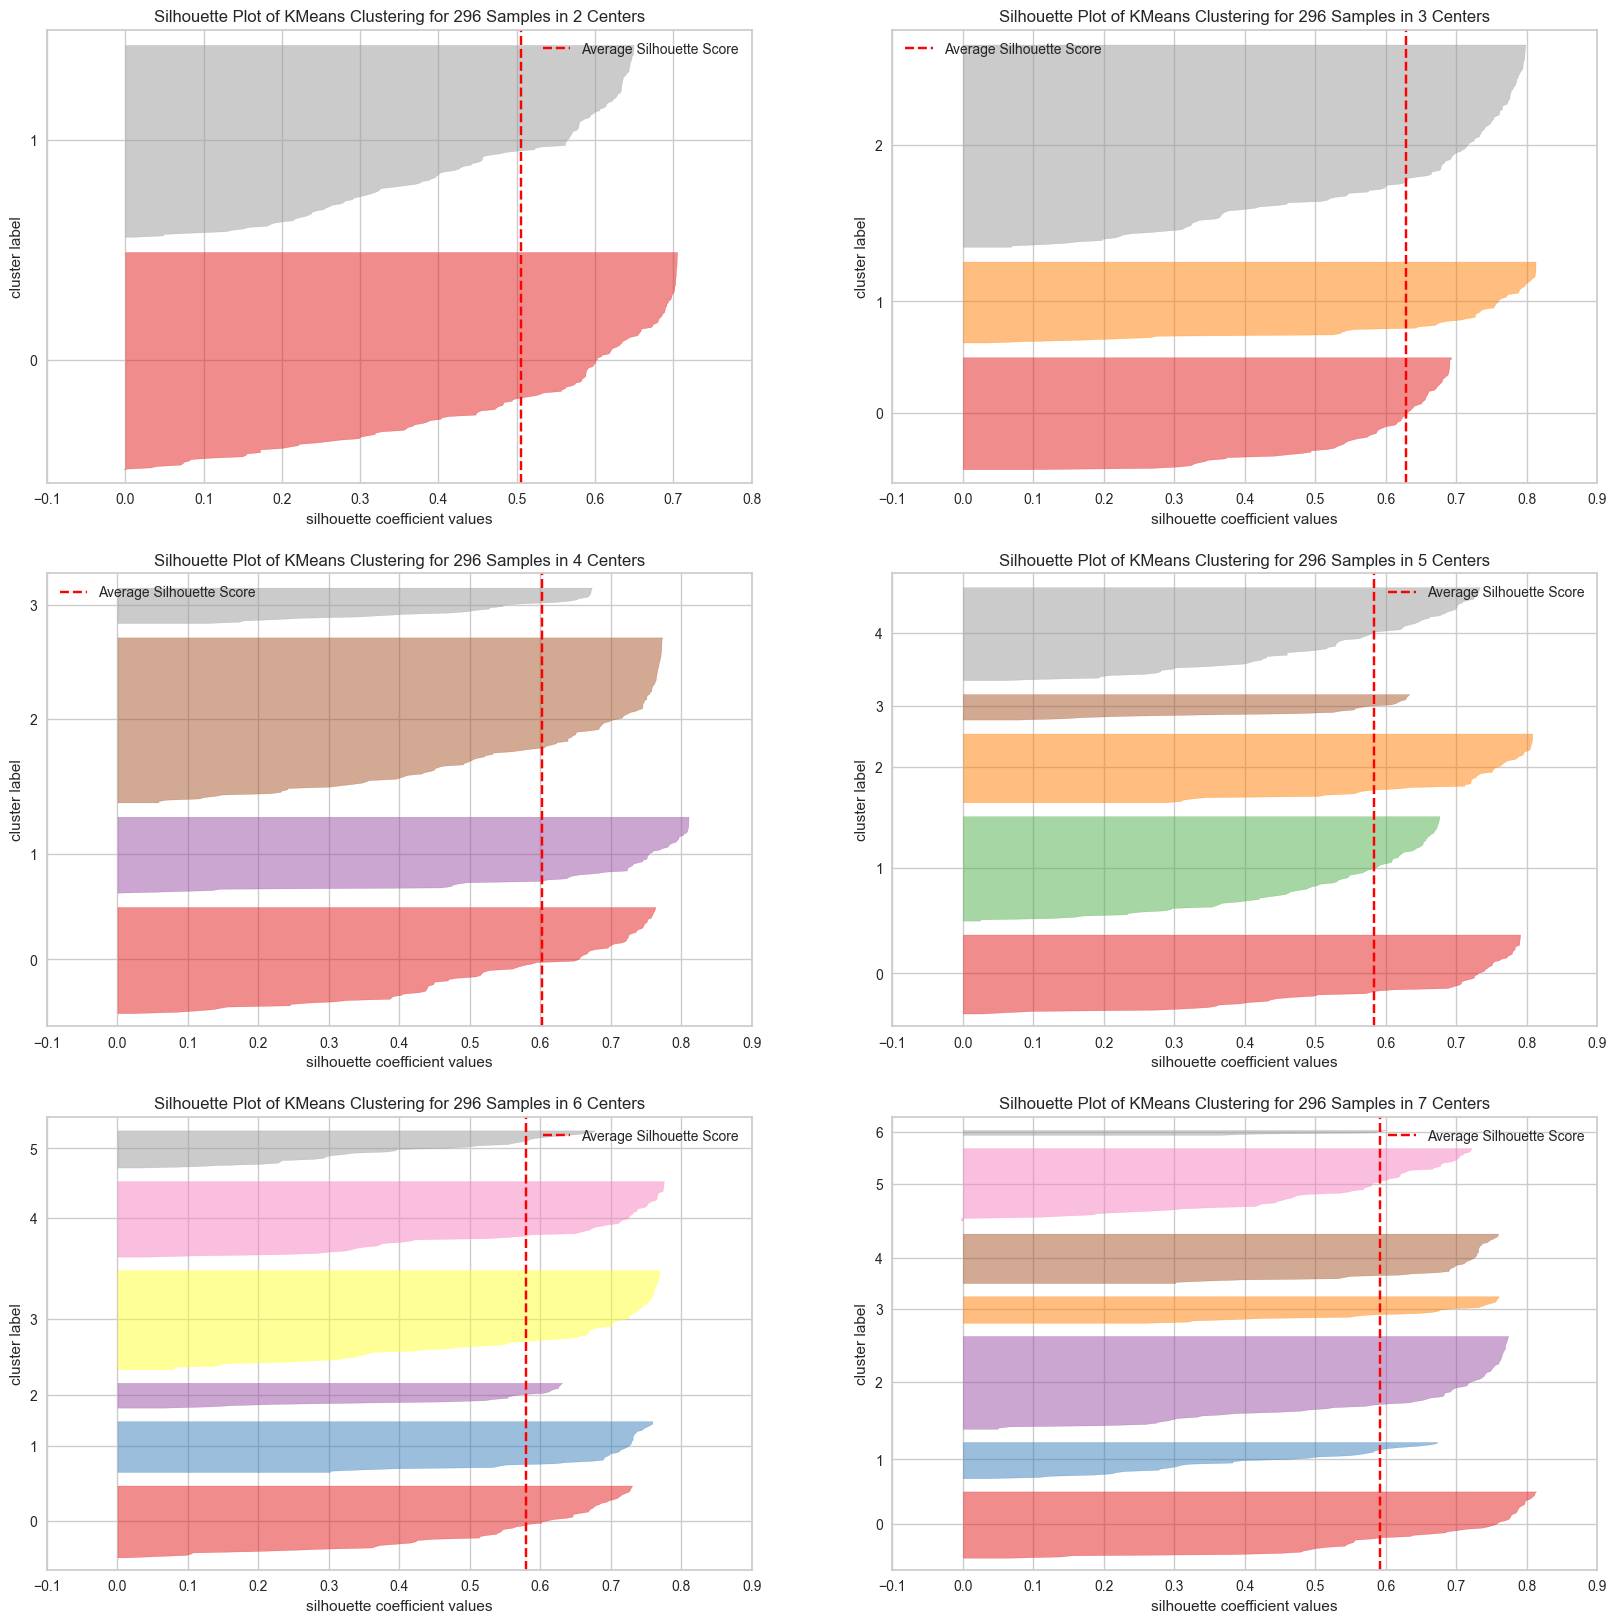

In [112]:
#SIlhouette
clusters = np.arange(2,8,1)
fig, ax = plt.subplots(3,2, figsize=(20,20))

for k in clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=50, max_iter=300, random_state=42)
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_train_emb_alvo)
    visualizer.finalize()

# 13 MODEL TRAINING

In [153]:
#kMEANS
k=3

kmeans = KMeans(n_clusters=k, init='k-means++', n_init=50, max_iter=300, random_state=42)

kmeans.fit(X_train_emb_alvo)

labels = kmeans.labels_

In [154]:
#WSS
print(f'WSS Score: {kmeans.inertia_:.3f}')

print(f'SS Score: {mt.silhouette_score(X_train_emb_alvo, labels):.3f}')

WSS Score: 7816883540485.243
SS Score: 0.628


## 14.0 CLUSTERS ANALYSIS

In [155]:
df_viz = X_train_emb_alvo.copy()
df_viz['clusters'] = labels

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

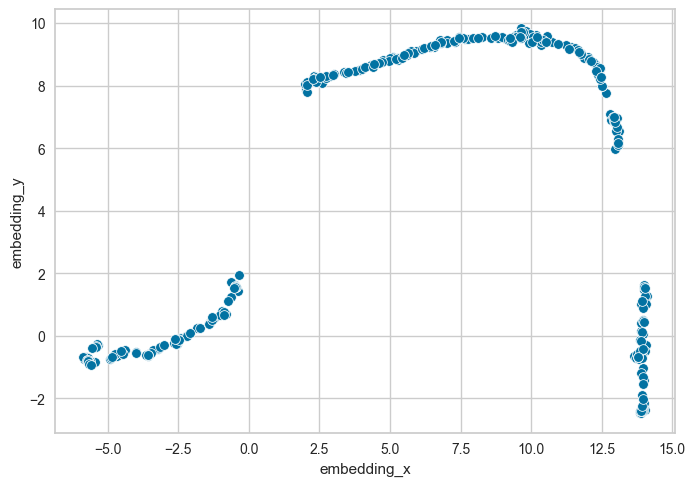

In [165]:
reducer = umap.UMAP(n_neighbors=70, random_state=42)
embedding = reducer.fit_transform(df_viz)

#embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                palette=sns.color_palette('hls', n_colors=len(df_viz['clusters'].unique())),
                data=df_umap)

## 15.0 RESULTS

In [166]:
df14 = X_test_class.copy()
df14['clusters'] = labels

In [170]:
df14

,codigo,nome,cidade,estado,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,...,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial,clusters
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,...,2197,4368,6681,7011,2247,5670,1501.0,2.402675e+05,2,1
161,35503020,Aclimação,São Paulo,SP,32791,2297,1017,2096,2197,5341,...,3704,2351,1946,827,291,1617,5920.0,1.525346e+06,2,0
162,355030285,Adventista,São Paulo,SP,104193,15070,7343,10631,8657,17749,...,1423,4875,8595,10082,3111,5776,1284.0,1.860776e+05,1,1
163,35503088,Água Branca,São Paulo,SP,12721,953,343,627,819,2142,...,1558,1032,915,361,84,404,6278.0,1.267278e+06,2,0
164,35503066,Água Funda,São Paulo,SP,48417,5078,2396,4018,3571,7388,...,1794,2986,4489,2836,1104,2553,1905.0,7.460072e+05,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,355030213,Vila Sônia,São Paulo,SP,34061,2908,1462,2253,2076,4579,...,2866,2219,2216,1227,306,1098,5285.0,1.262652e+06,2,0
452,355030207,Vila Suzana,São Paulo,SP,35403,4127,1890,2678,2433,5855,...,2458,1186,1166,918,209,3840,7418.0,1.467358e+06,2,0
453,355030162,Vila Terezinha,São Paulo,SP,122359,18304,9304,13258,9965,19248,...,1758,4517,9450,11473,3218,7540,1252.0,7.132221e+04,1,1
454,355030157,Vila Zatt,São Paulo,SP,125864,14670,7305,11225,9338,18841,...,5093,8063,10012,8082,2856,6853,1936.0,1.078105e+05,2,1


In [167]:
df14.columns

Index(['codigo', 'nome', 'cidade', 'estado', 'população', 'pop_ate9',
       'pop_de10a14', 'pop_de15a19', 'pop_de20a24', 'pop_de25a34',
       'pop_de35a49', 'pop_de50a59', 'pop_mais_de60', 'domicilios_a1',
       'domicilios_a2', 'domicilios_b1', 'domicilios_b2', 'domicilios_c1',
       'domicilios_c2', 'domicilios_d', 'domicilios_e', 'renda_media',
       'faturamento', 'potencial', 'clusters'],
      dtype='object')

In [174]:
df_renda = df14.loc[:,['clusters','renda_media',]].groupby('clusters').mean().reset_index()

df_idade1 = df14.loc[:,['clusters','pop_de25a34',]].groupby('clusters').mean().reset_index()

df_idade2 = df14.loc[:,['clusters','pop_de35a49',]].groupby('clusters').mean().reset_index()

df_fat = df14.loc[:,['clusters','faturamento']].groupby('clusters').mean().reset_index()

df_resume = (pd.merge(df_renda, df_idade1, on='clusters', how='left')
              .merge(df_idade2, on='clusters', how='left')
              .merge(df_fat, on='clusters', how='left'))

In [175]:
df_resume

,clusters,renda_media,pop_de25a34,pop_de35a49,faturamento
0,0,8365.797619,4117.678571,6091.500000,1.402262e+06
1,1,1353.606557,14697.819672,20362.672131,2.553860e+05
2,2,2745.535588,4396.933775,6297.622517,8.759132e+05


In [180]:
df14.loc[df14['clusters'] == 0,['nome','potencial']]

,nome,potencial
161,Aclimação,2
163,Água Branca,2
165,Água Rasa,2
167,Alfredo Pujol,2
168,Alto Da Lapa,2
...,...,...
443,Vila Olímpia,2
445,Vila Prudente,2
448,Vila Santa Catarina,2
451,Vila Sônia,2
